In [17]:
import yaml
from pathlib import Path
from torchvision.ops import boxes
from ultralytics import YOLO
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches

In [2]:
def setup_yolo_project(data_yaml_path):
    """
    Setup YOLOv8 project structure and configuration
    """
    # Load the data configuration
    with open(data_yaml_path, 'r') as file:
        data_config = yaml.safe_load(file)

    # Update paths if needed
    base_dir = Path(data_yaml_path).parent
    for key in ['train', 'val', 'test']:
        if key in data_config:
            data_config[key] = str(Path(base_dir) / data_config[key])

    # Save updated config
    with open(data_yaml_path, 'w') as file:
        yaml.dump(data_config, file)

In [32]:
def train_yolo_model(data_yaml_path, epochs=100):
    """
    Train YOLOv8 model with data augmentation
    """
    # Load YOLOv8 nano model
    model = YOLO('yolov8n.pt')

    # Training configuration with augmentation
    config = {
        'data': data_yaml_path,
        'epochs': epochs,
        'imgsz': 640,
        'batch': 16,
        'device': 'cuda:0',  # Use 'cpu' if no GPU available

        # Data augmentation settings
        'augment': True,
        'degrees': 10.0,  # Random rotation
        'translate': 0.1,  # Random translation
        'scale': 0.5,  # Random scaling
        'fliplr': 0.5,  # Horizontal flip probability
        'mosaic': 1.0,  # Mosaic augmentation
        'mixup': 0.5,  # Mixup augmentation

        # Training parameters
        'patience': 50,  # Early stopping patience
        'optimizer': 'auto',
        'lr0': 0.01,  # Initial learning rate
        'lrf': 0.01,  # Final learning rate
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,

        # Save best model
        'save': True,
        'save_period': -1,  # Save only best model
    }

    # Start training
    results = model.train(**config)
    return results, model

In [2]:
def export_model(model_path, format='tflite'):
    model = YOLO(model_path)

    # Export the model
    model.export(format=format)

In [3]:
export_model('../models/own_seat.pt', format='onnx')

Ultralytics 8.3.76  Python-3.12.7 torch-2.5.1+cu121 CPU (12th Gen Intel Core(TM) i7-12650H)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '..\models\own_seat.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success  2.7s, saved as '..\models\own_seat.onnx' (11.7 MB)

Export complete (4.1s)
Results saved to C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\models
Predict:         yolo predict task=detect model=..\models\own_seat.onnx imgsz=640  
Validate:        yolo val task=detect model=..\models\own_seat.onnx imgsz=640 data=data/data.yaml  
Visualize:       https://netron.app


In [35]:
def evaluate_model(model, data_yaml_path, confidence_threshold=0.25, iou_threshold=0.5):
    """
    Comprehensive model evaluation with detailed metrics
    """
    # Run validation
    metrics = model.val(data=data_yaml_path,
                        conf=confidence_threshold,
                        iou=iou_threshold,
                        verbose=True)

    # Extract detailed metrics
    evaluation_results = {
        'mAP50': metrics.box.map50,  # mAP at IoU=0.50
        'mAP50-95': metrics.box.map,  # mAP at IoU=0.50:0.95
        'precision': metrics.box.mp,  # Mean precision
        'recall': metrics.box.mr,  # Mean recall
        'f1-score': metrics.box.f1,  # F1 score
        'inference_time': metrics.speed['inference'],  # ms per image
        'preprocessing_time': metrics.speed['preprocess'],
        'postprocessing_time': metrics.speed['postprocess']
    }

    print("\nDetailed Evaluation Results:")
    print("-" * 50)
    for metric, value in evaluation_results.items():
        # Check if value is a numpy ndarray
        if isinstance(value, np.ndarray):
            value = value.item()  # Convert to scalar value
        print(f"{metric}: {value:.4f}")

    return evaluation_results

In [33]:
data_yaml_path = "data/data.yaml"

setup_yolo_project(data_yaml_path)

In [ ]:
results, model = train_yolo_model(data_yaml_path)

In [36]:
print("\nRunning model evaluation...")
evaluation_results = evaluate_model(model, data_yaml_path)


Running model evaluation...
Ultralytics 8.3.76  Python-3.12.7 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training_empty_seat\data\valid\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.01s/it]


                   all         30         61      0.848      0.721      0.829      0.634
Speed: 4.0ms preprocess, 27.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\runs\detect\train132

Detailed Evaluation Results:
--------------------------------------------------
mAP50: 0.8285
mAP50-95: 0.6341
precision: 0.8482
recall: 0.7213
f1-score: 0.7796
inference_time: 27.0414
preprocessing_time: 3.9870
postprocessing_time: 1.7047


In [33]:
def visualize_predictions_vs_ground_truth(model_path, image_path):
    # Load the image
    img = Image.open(image_path)
    img = np.array(img)

    # Perform predictions using the model
    model = YOLO(model_path).to(device="cpu")
    results = model(image_path)
    device = model.device
    print(f"Model is using: {device}")

    # Get predictions
    predictions = results[0].boxes.xyxy.cpu().numpy()
    pred_labels = results[0].boxes.cls.cpu().numpy()
    pred_confidences = results[0].boxes.conf.cpu().numpy()

    # Create figure
    plt.figure(figsize=(12, 8))
    plt.imshow(img)

    # Plot predicted boxes (red)
    for pred_box, pred_label, pred_conf in zip(predictions, pred_labels, pred_confidences):
        xmin, ymin, xmax, ymax = pred_box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(xmin, ymin, f'Pred: {int(pred_label)} {pred_conf:.2f}',
                 color='red', fontsize=10, verticalalignment='bottom')

    plt.title("Predictions vs Ground Truth")
    plt.axis('on')
    plt.show()


image 1/1 C:\Users\alpay\Documents\jaar3\Lab\vision-app-backend\model_training_empty_seat\test_seats_3.jpg: 640x640 5 empty-seat-frontals, 126.5ms
Speed: 4.4ms preprocess, 126.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Model is using: cpu


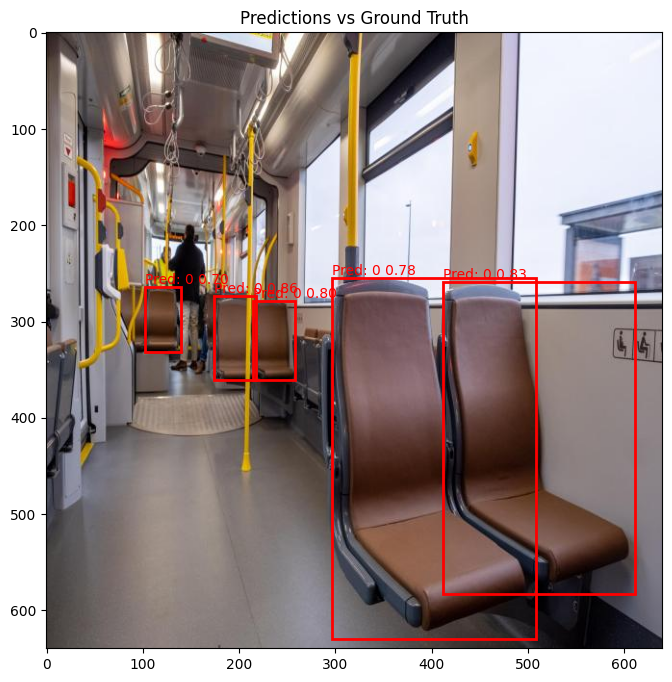

In [37]:
image_path = "test_seats_3.jpg"
model_path = "../models/own_seat.pt"
# Visualize
visualize_predictions_vs_ground_truth(model_path, image_path)

In [39]:
import onnxruntime as ort
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from PIL import Image

# Define a confidence threshold for predictions
CONF_THRESHOLD = 0.7  # Only show boxes with confidence >= 80%

def preprocess_image(image_path, input_size=(640, 640)):
    """Preprocess the input image for ONNX model."""
    img = Image.open(image_path)
    original_shape = img.size  # (width, height)
    img = np.array(img)
    resized_image = cv2.resize(img, input_size)  # Resize image
    image_data = resized_image / 255.0  # Normalize to [0, 1]
    image_data = np.transpose(image_data, (2, 0, 1))  # HWC to CHW
    image_data = np.expand_dims(image_data, axis=0).astype(np.float32)  # Add batch dimension
    return image_data, original_shape, img

def postprocess_output(outputs, original_shape, input_size=(640, 640), conf_threshold=CONF_THRESHOLD):
    """Postprocess the ONNX model outputs to extract bounding boxes."""
    boxes = []
    confidences = []
    output = np.squeeze(outputs[0])  # Remove batch dimension -> shape (5, 8400)

    # Transpose to (8400, 5) where each row is (x_center, y_center, w, h, conf)
    output = output.T

    for detection in output:
        x_center, y_center, width, height, confidence = detection

        if confidence >= conf_threshold:
            # Convert (center x, center y, width, height) to (x_min, y_min, x_max, y_max)
            x_min = (x_center - width / 2) * original_shape[0] / input_size[0]
            y_min = (y_center - height / 2) * original_shape[1] / input_size[1]
            x_max = (x_center + width / 2) * original_shape[0] / input_size[0]
            y_max = (y_center + height / 2) * original_shape[1] / input_size[1]

            boxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            confidences.append(float(confidence))  # Store confidence for display

    return boxes, confidences

def draw_boxes(image, boxes, confidences):
    """Draw bounding boxes and confidence scores on the image."""
    for box, confidence in zip(boxes, confidences):
        x_min, y_min, x_max, y_max = box
        label = f"{confidence:.2f}"  # Format confidence as percentage
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

def visualize_predictions_vs_ground_truth_onnx(model_path, image_path):
    # Load ONNX model from disk
    session = ort.InferenceSession(model_path)

    # Load and preprocess the image
    input_image, original_shape, img = preprocess_image(image_path)

    # Run inference
    input_name = session.get_inputs()[0].name
    outputs = session.run(None, {input_name: input_image})

    # Postprocess the output to extract boxes and confidences
    boxes, confidences = postprocess_output(outputs, original_shape)

    # Create figure
    plt.figure(figsize=(12, 8))
    plt.imshow(img)

    # Plot predicted boxes (red)
    for box, confidence in zip(boxes, confidences):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(xmin, ymin, f'Pred: {confidence:.2f}',
                 color='red', fontsize=10, verticalalignment='bottom')

    plt.title("Predictions vs Ground Truth")
    plt.axis('on')
    plt.show()

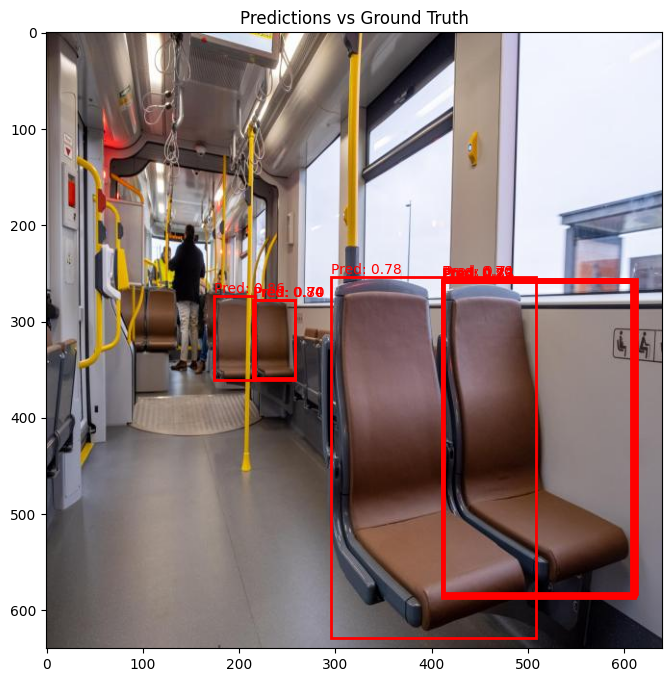

In [40]:
onnx_model_path = '../models/own_seat.onnx'
image_path = 'test_seats_3.jpg'
visualize_predictions_vs_ground_truth_onnx(onnx_model_path, image_path)

In [30]:
def check_onnx_device(model_path):
    # Create an ONNX runtime session with the model
    providers = ort.get_available_providers()

    # Check if CUDA (GPU) is available
    if 'CUDAExecutionProvider' in providers:
        print("Using GPU (CUDA) for inference.")
        session = ort.InferenceSession(model_path, providers=['CUDAExecutionProvider'])
    else:
        print("Using CPU for inference.")
        session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])

    # Print the available providers to see what options we have
    print("Available Execution Providers:", providers)
    return session
onnx_model_path = '../models/own_seat.onnx'
session = check_onnx_device(onnx_model_path)

Using CPU for inference.
Available Execution Providers: ['AzureExecutionProvider', 'CPUExecutionProvider']
